Predict Loan Eligibility for Dream Housing Finance company

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers.

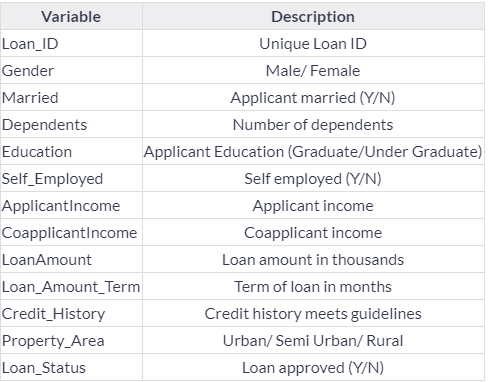

Your model performance will be evaluated on the basis of your prediction of loan status for the test data (test.csv), which contains similar data-points as train except for the loan status to be predicted. Your submission needs to be in the format as shown in sample submission.

We at our end, have the actual loan status for the test dataset, against which your predictions will be evaluated. We will use the Accuracy value to judge your response.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 351

In [2]:
df = pd.read_csv('train_ctrUa4K.csv')
TEST_DF = pd.read_csv('test_lAUu6dG.csv')

In [3]:
print(df.info())
print()
TEST_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 

In [4]:
print(df.isna().sum())
print()
TEST_DF.isna().sum()

#There are missing values on both sets

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64



Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [5]:
#Dropping Load ID

df.drop('Loan_ID', axis = 1, inplace = True)
TEST_DF.drop('Loan_ID', axis = 1, inplace = True)

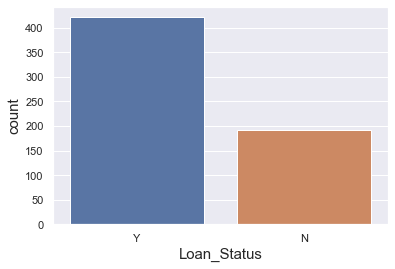

In [6]:
sns.countplot(df.Loan_Status);

In [7]:
df.Loan_Status.value_counts(normalize = True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

The Data is quite imbalanced, where the Those who didnt get their loan approved are the minority class and those who did get their loan approved are the majority class. Hence, we should suitable metrics such as F1 score, ROC-AUC score etc in order to validate the model we will be creating for this dataset.

# Train Test Split 

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Loan_Status', axis = 1)
y = df.Loan_Status.to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = seed, 
                                                    stratify = y) 

for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(inplace = True, drop = True)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((521, 11), (93, 11), (521, 1), (93, 1))

# EDA

EDA will only be done on the train set

### Univariate EDA

First, plotting all categorical variables

In [10]:
cat_cols = X_train.loc[:,X_train.dtypes=='object'].columns
cat_cols

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')

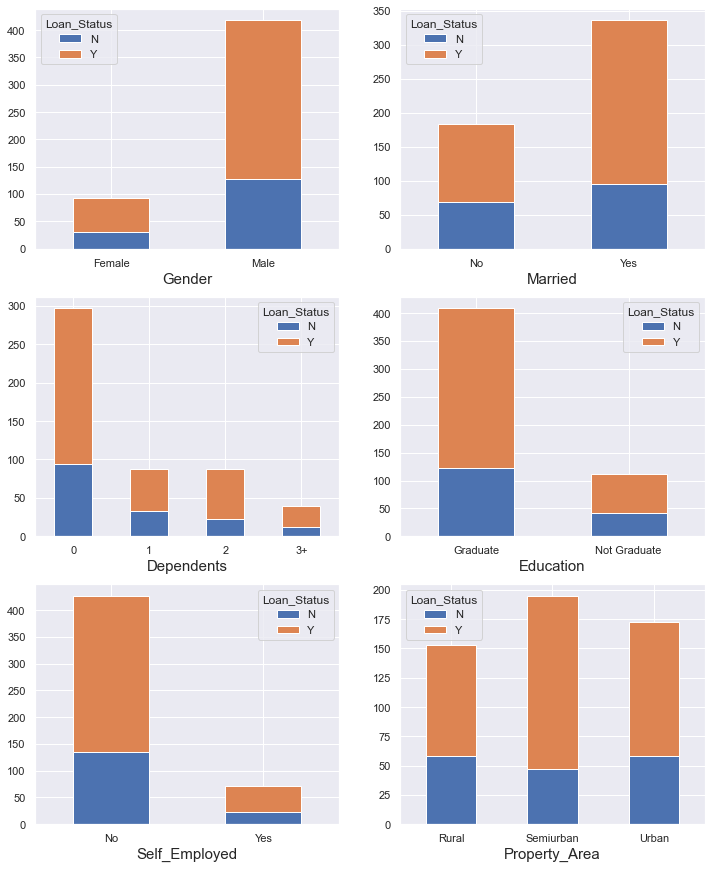

In [11]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

for col, ax in zip(cat_cols, axes.flatten()):
    pd.crosstab(index = X_train[col], columns = y_train.Loan_Status).\
                            plot(kind = 'bar', stacked = True, rot = 0, ax = ax);

1. Majority of the loan applicants are Male. 
2. Majority of the applicants are Married.
3. Majority of the applicants have no dependents. Laterwards I will look more closely into this feature.
4. Majority of the applicants have graduated.
5. Most of the applicants are not self employed.
6. There is an almost equal frequency of those applicants staying in a rural, semiurban and urban areas.

Overall, majority of the applicants have their loan status approved. We will look into the proportion of loan status for each of the features later.

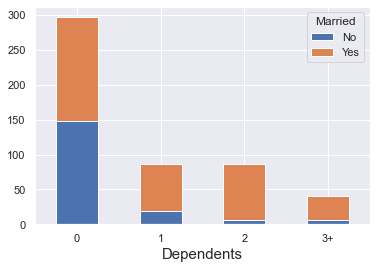

In [12]:
#Taking a closer look at the Dependents feature

pd.crosstab(index = X_train.Dependents, columns = X_train.Married).plot(kind = 'bar', 
                                                                        stacked = True, 
                                                                        rot = 0);

In [13]:
X_train[(X_train.Dependents=='0')&(X_train.Married=='Yes')]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
7,Male,Yes,0,Not Graduate,No,2253,2033.0,110.0,360.0,1.0,Rural
9,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural
12,Female,Yes,0,Not Graduate,No,1928,1644.0,100.0,360.0,1.0,Semiurban
15,Male,Yes,0,Graduate,No,3707,3166.0,182.0,NaN,1.0,Rural
17,Male,Yes,0,Graduate,No,5829,0.0,138.0,360.0,1.0,Rural
...,...,...,...,...,...,...,...,...,...,...,...
513,Male,Yes,0,Graduate,No,2383,3334.0,172.0,360.0,1.0,Semiurban
514,Male,Yes,0,Not Graduate,No,4887,0.0,133.0,360.0,1.0,Rural
518,Male,Yes,0,Not Graduate,No,4467,0.0,120.0,360.0,NaN,Rural
519,Male,Yes,0,Not Graduate,No,1668,3890.0,201.0,360.0,0.0,Semiurban


*There is a discrepency with the 0 category of the dependent feature. Half of the applicants having zero dependents are married. Shouldn't the ones who are married have atleast one dependent?*

**In the next section, we look at the proportion of loan status for each of the categorical features**

In [14]:
#Creating a lamda function that calculates the proportion of each category for that feature

prop = lambda x: x/x.sum()

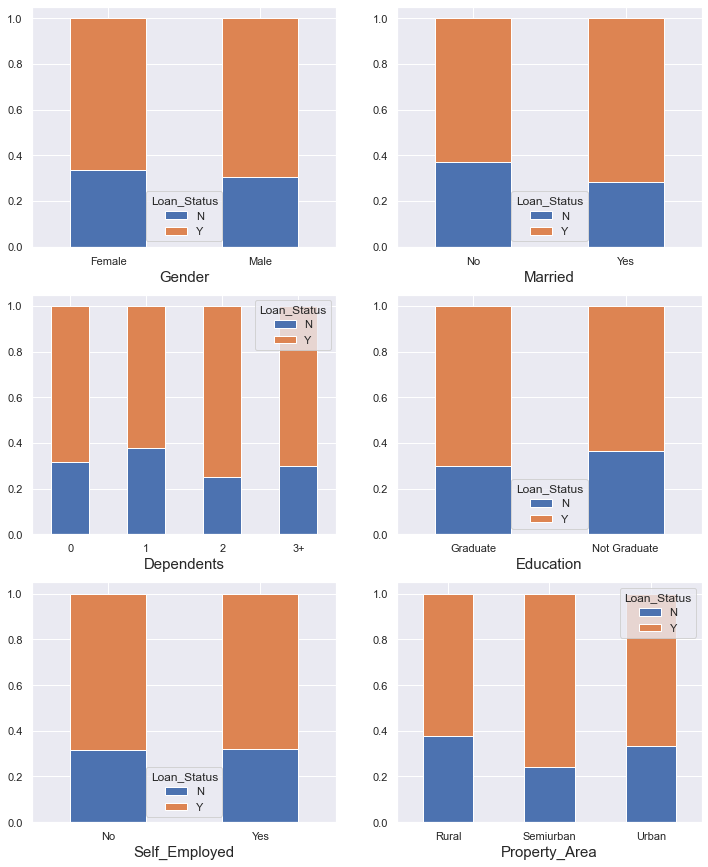

In [15]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

for col, ax in zip(cat_cols, axes.flatten()):
    pd.crosstab(index = X_train[col], columns = y_train.Loan_Status).apply(prop, axis = 1).\
                                        plot(kind = 'bar', stacked = True, rot = 0, ax = ax);

From the above plots, the proportion of loan status is the same for gender and self_employed. This could mean there is no apparent association between loan status and these 2 variables.

Whereas for the rest of the categorical variables, the proportion differs across different categories.

1. Those who are not married have a higher proportion of those loan Status not being approved.
2. Applicants with 1 or 3+ dependents have slightly proportion of those with  loan status not approved.
3. Applicants who hasn't graduated has a higher proportion of those with  loan status not approved.
4. Applicants who are from rural and urban areas have a higher proportion of those with  loan status not approved.

Now, looking into numerical variables

In [16]:
X_train.loc[:,X_train.dtypes!='object'].columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

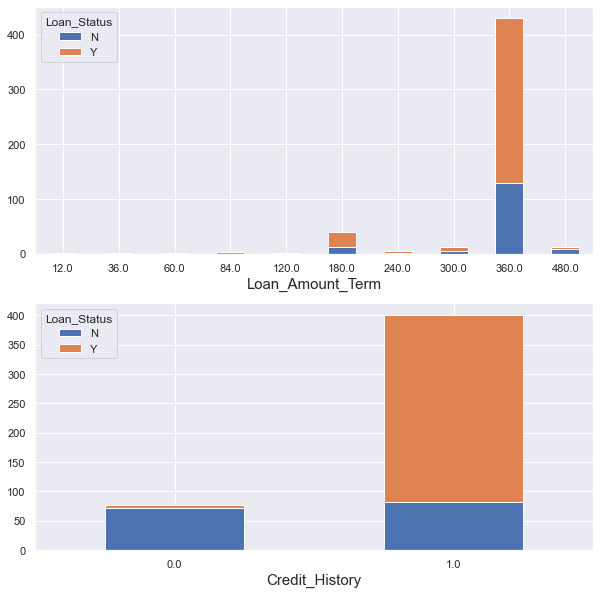

In [17]:
fig, axes = plt.subplots(2,1, figsize = (10,10))

for col, ax in zip(['Loan_Amount_Term', 'Credit_History'], axes.flatten()):
    pd.crosstab(index = X_train[col], columns = y_train.Loan_Status).plot(kind = 'bar',
                                                                          stacked = True,
                                                                          rot = 0,
                                                                          ax = ax);

Most of the applicants applied for 360 months loan term. Lets look at the proportion of loan status. This feature has higher cardinality compared to other features. Hence, in order to reduce the cardinality, discretization techniques will be applied to this variable.

For the Credit History Feature, almost all applicants with a bad credit history has got their loan Status rejected whereas those with a good credit history has a higher proportion of those with approved loan status.

Credit history seems to be a key feature in determining loan Status. Therefore, we need to establish what attributes contribute to bad credit history.

In [18]:
X_train.LoanAmount = X_train.LoanAmount * 1000
X_test.LoanAmount = X_test.LoanAmount * 1000
TEST_DF.LoanAmount = TEST_DF.LoanAmount * 1000

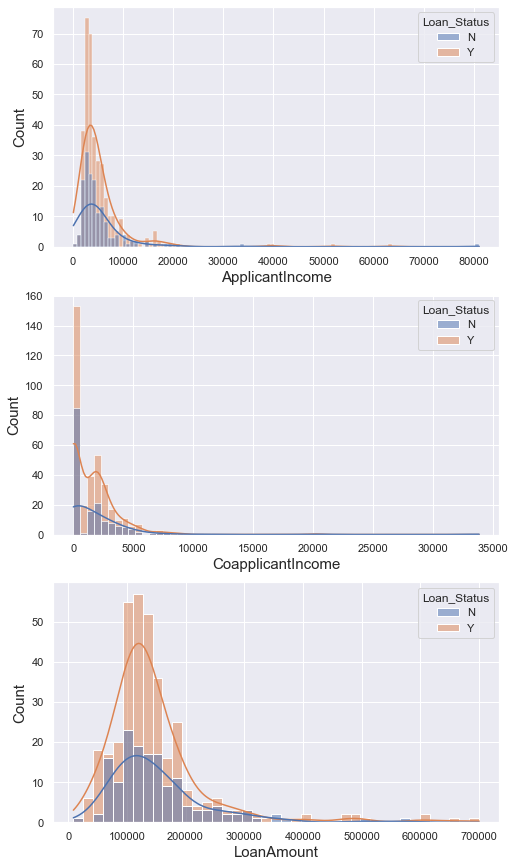

In [19]:
fig, axes = plt.subplots(3,1, figsize = (8,15))

for col, ax in zip(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], axes.flatten()):
    temp_df = pd.concat([X_train[col], y_train], axis = 1)
    sns.histplot(x = col, data = temp_df, hue = 'Loan_Status', ax = ax, kde = True);

In [20]:
X_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,521.0,5473.418426,6277.361331,150.0,2876.0,3858.0,5935.0,81000.0
CoapplicantIncome,521.0,1583.003685,2524.062256,0.0,0.0,1213.0,2330.0,33837.0
LoanAmount,501.0,146774.451098,85910.715431,9000.0,100000.0,128000.0,168000.0,700000.0


All of these features are skewed. Hence suitable variable transformations needs to be applied.

1. The median Applicant income is around 3860. 
2. Most of the coapplicants are not employed, hence have zero income. The median income is around 1200. 
3. The median amount applied for the loan by the applicant is around 128 thousand.

## Multivariate EDA & Feature Engineering

#### Missing Value Imputation

Visualizing the spread of missing values across the features for all data sets.

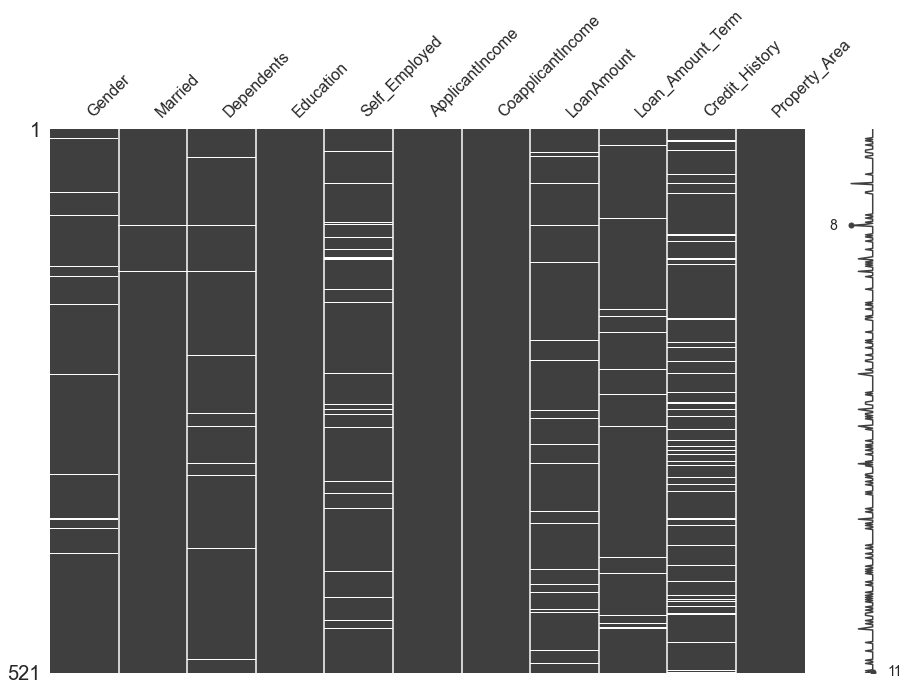

In [21]:
import missingno as msno
msno.matrix(X_train, figsize = (15,10));

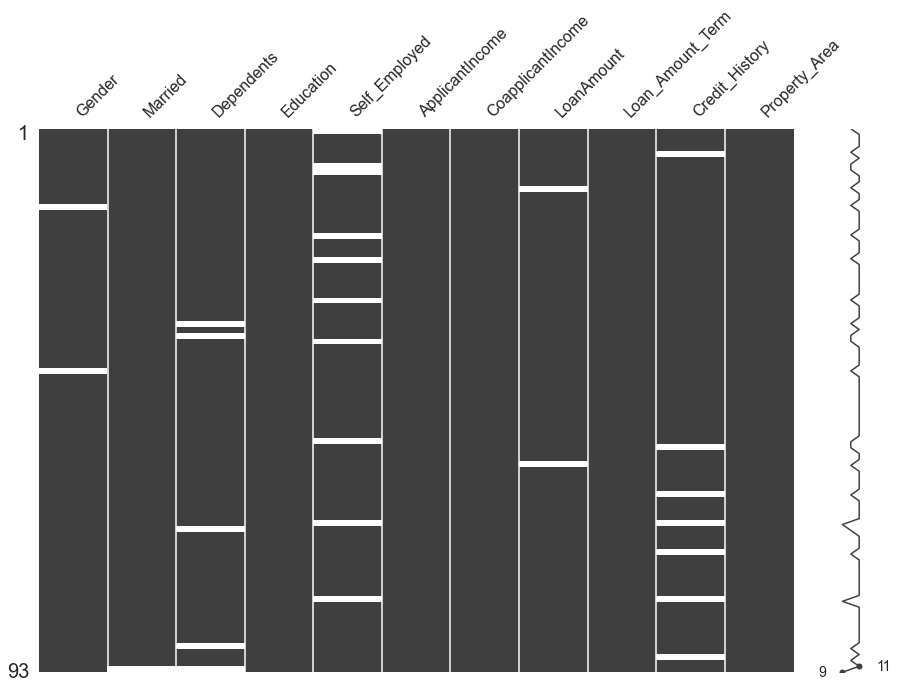

In [22]:
msno.matrix(X_test, figsize = (15,10));

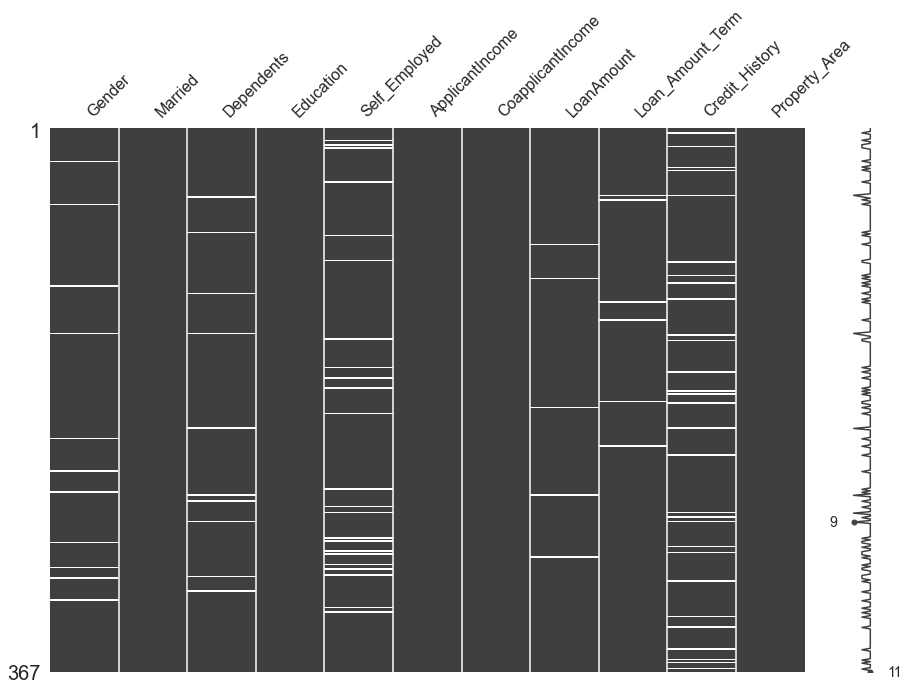

In [23]:
msno.matrix(TEST_DF, figsize = (15,10));

* The above three plots represents the missing values across each of the datasets. The white lines represents missing values while the black area represents the data with values. It is not clear immediatly whether these values are **missing completly at random (MCAR), missing at random (MAR), or missing not at random (MNAR)**. <br>
<br>
* Most of the missing values are spread across credit history. As credit history might the major attribute that determines whether the applicant will get his loan approved or not, it might be for that reason this section was intentionally left blank by the applicant, assuming the applicant dont have a good credit history. So, this section is more likely to be MNAR. <br>
<br>
* For all other features, its not clear the reasons for the presence of missing values. There are missing values across multiple columns in all three datasets. Therefore, I will assume that ***all*** of the missing values across al of these features are ***MAR***. This means that the values for these missing values can be inferred utilizing information from other features. <br>
<br>
* I will impute all of these missing values using **MissForest imputation**, which imputes the data using RandomForest algorithm. But, all the string values within the categorical columns has to be converted to floats, only than can MissForest impute missing values. <br>

In [24]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,2,Not Graduate,No,6125,1625.0,187000.0,480.0,1.0,Semiurban
1,Male,Yes,2,Graduate,No,4167,1447.0,158000.0,360.0,1.0,Rural
2,Male,Yes,3+,Graduate,No,4691,0.0,100000.0,360.0,1.0,Semiurban
3,Male,No,0,Graduate,No,4166,7210.0,184000.0,360.0,1.0,Urban
4,Male,Yes,2,Graduate,Yes,2726,0.0,106000.0,360.0,0.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
516,Male,Yes,2,Graduate,No,5935,0.0,133000.0,360.0,1.0,Semiurban
517,Female,No,0,Not Graduate,No,3400,0.0,95000.0,360.0,1.0,Rural
518,Male,Yes,0,Not Graduate,No,4467,0.0,120000.0,360.0,NaN,Rural
519,Male,Yes,0,Not Graduate,No,1668,3890.0,201000.0,360.0,0.0,Semiurban


In [25]:
X_train.Gender = np.where(X_train.Gender.isna(), np.nan, np.where(X_train.Gender == 'Female', 1,0))
X_test.Gender = np.where(X_test.Gender.isna(), np.nan, np.where(X_test.Gender == 'Female', 1,0))
TEST_DF.Gender = np.where(TEST_DF.Gender.isna(), np.nan, np.where(TEST_DF.Gender == 'Female', 1,0))

In [26]:
X_train.Married = np.where(X_train.Married.isna(), np.nan, np.where(X_train.Married == 'Yes', 1,0))
X_test.Married = np.where(X_test.Married.isna(), np.nan, np.where(X_test.Married == 'Yes', 1,0))
TEST_DF.Married = np.where(TEST_DF.Married.isna(), np.nan, np.where(TEST_DF.Married == 'Yes', 1,0))

In [27]:
X_train.Dependents = X_train.Dependents.map({'0': 0, '1': 1, '2' : 2, '3+' : 3})
X_test.Dependents = X_test.Dependents.map({'0': 0, '1': 1, '2' : 2, '3+' : 3})
TEST_DF.Dependents = TEST_DF.Dependents.map({'0': 0, '1': 1, '2' : 2, '3+' : 3})

In [28]:
X_train.Self_Employed = np.where(X_train.Self_Employed.isna(), np.nan, 
                                 np.where(X_train.Self_Employed == 'Yes', 1,0))

X_test.Self_Employed = np.where(X_test.Self_Employed.isna(), np.nan, 
                                 np.where(X_test.Self_Employed == 'Yes', 1,0))

TEST_DF.Self_Employed = np.where(TEST_DF.Self_Employed.isna(), np.nan, 
                                 np.where(TEST_DF.Self_Employed == 'Yes', 1,0))

In [29]:
X_train.Education = np.where(X_train.Education == 'Graduate', 1, 0)
X_test.Education = np.where(X_test.Education == 'Graduate', 1, 0)
TEST_DF.Education = np.where(TEST_DF.Education == 'Graduate', 1, 0)

In [30]:
X_train.Property_Area = X_train.Property_Area.map({'Rural': 0,  'Semiurban': 1, 'Urban' : 2})
X_test.Property_Area = X_test.Property_Area.map({'Rural': 0,  'Semiurban': 1, 'Urban' : 2})
TEST_DF.Property_Area = TEST_DF.Property_Area.map({'Rural': 0,  'Semiurban': 1, 'Urban' : 2})

In [31]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.0,1.0,2.0,0,0.0,6125,1625.0,187000.0,480.0,1.0,1
1,0.0,1.0,2.0,1,0.0,4167,1447.0,158000.0,360.0,1.0,0
2,0.0,1.0,3.0,1,0.0,4691,0.0,100000.0,360.0,1.0,1
3,0.0,0.0,0.0,1,0.0,4166,7210.0,184000.0,360.0,1.0,2
4,0.0,1.0,2.0,1,1.0,2726,0.0,106000.0,360.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
516,0.0,1.0,2.0,1,0.0,5935,0.0,133000.0,360.0,1.0,1
517,1.0,0.0,0.0,0,0.0,3400,0.0,95000.0,360.0,1.0,0
518,0.0,1.0,0.0,0,0.0,4467,0.0,120000.0,360.0,NaN,0
519,0.0,1.0,0.0,0,0.0,1668,3890.0,201000.0,360.0,0.0,1


In [32]:
#Missing Value Imputation with MissForest

from missingpy import MissForest
imputer = MissForest(random_state = seed)

imputer.fit(X_train, cat_vars=[0,1,2,3,4,8,9,10])

X_train = pd.DataFrame(imputer.transform(X_train), columns = df.columns[:-1])
X_test = pd.DataFrame(imputer.transform(X_test), columns = df.columns[:-1])
TEST_DF = pd.DataFrame(imputer.transform(TEST_DF), columns = df.columns[:-1])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [33]:
print(X_train.isna().sum()), 
print()
print(X_test.isna().sum())
print()
print(TEST_DF.isna().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


All of the missing values has been imputed.

Next, lets look for association between features.

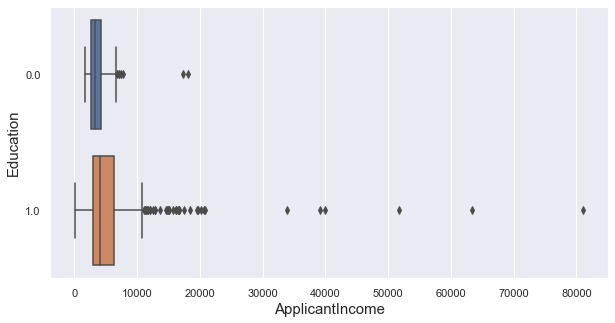

In [34]:
# Salary distribution based on Education

plt.figure(figsize = (10,5))
sns.boxplot(y = 'Education', x = 'ApplicantIncome', data = X_train, orient = 'h');

** 0.0  - Not Graduate ** <br>
** 1.0 - Graduate ** <br>

There are considerable difference between the income of graduates and not graduate category. Among the not graduated category, loan was approved for those with a higher median salary.
 
Interestingly within the graduate category, there are some noticable outliers. Within this category, the loan was not approved for some applicants, even though the median salary was considerable higher.

Next, we will discretise some of the features and fnd its association with the target variable.

In [35]:
X_train['LoanAmount'].describe()

count       521.000000
mean     147115.239923
std       86062.749777
min        9000.000000
25%      100000.000000
50%      128000.000000
75%      168000.000000
max      700000.000000
Name: LoanAmount, dtype: float64

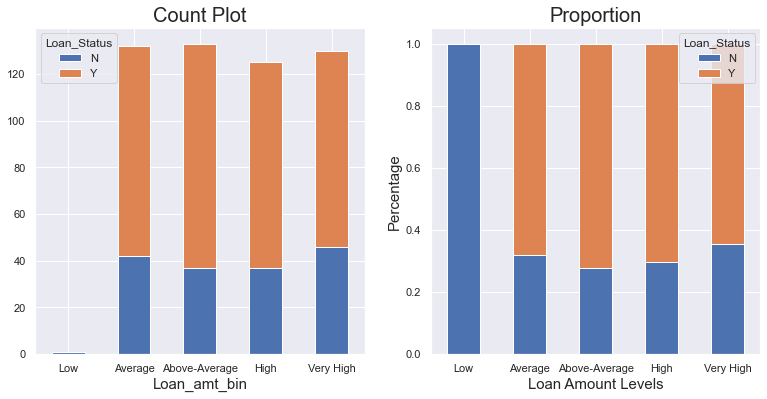

In [36]:
#Loan amounts

bins = [0, 9000.5, 100000.5, 128000.5, 168000.5, 700000.5] #Keeping same bins as main applicants incomes
groups = ['Low', 'Average', 'Above-Average', 'High', 'Very High']
X_train['Loan_amt_bin'] = pd.cut(x = X_train['LoanAmount'], bins = bins, labels = groups)

Loan_amt_bin = pd.crosstab(index = X_train.Loan_amt_bin, columns = y_train['Loan_Status'])


fig, ax = plt.subplots(1, 2, figsize = (13,6))

Loan_amt_bin.plot(kind = 'bar', stacked = True, rot = 0, title = 'Count Plot', ax = ax[0]);


Loan_amt_bin.div(Loan_amt_bin.sum(1), axis = 0).plot(kind = 'bar', 
                                                     stacked = True,
                                                     rot = 0, 
                                                     ax = ax[1])
plt.title('Proportion')
plt.xlabel("Loan Amount Levels")
plt.ylabel('Percentage');

Although most of the loan amount levels have almost equal proportions of approved and not approved status, higher loan amounts tend to have higher chances of loans not getting approved.

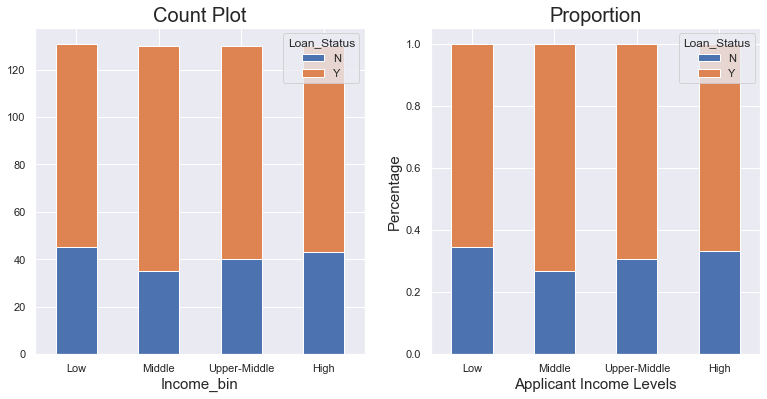

In [37]:
#In terms of applicant income.

bins = [0,2876.5, 3858.5, 5935.5, 81000.5]
groups = ['Low', 'Middle', 'Upper-Middle', 'High']
X_train['Income_bin'] = pd.cut(x = X_train['ApplicantIncome'], bins = bins, labels = groups)

Income_bin = pd.crosstab(index = X_train.Income_bin, columns = y_train['Loan_Status'])

fig, ax = plt.subplots(1, 2, figsize = (13,6))

Income_bin.plot(kind = 'bar', stacked = True, rot = 0, title = 'Count Plot', ax = ax[0]);

Income_bin.div(Income_bin.sum(1), axis = 0).plot(kind = 'bar', 
                                                 stacked = True, 
                                                 rot = 0, title = 'Proportion', 
                                                 ax = ax[1]);

plt.xlabel('Applicant Income Levels')
plt.ylabel('Percentage');

It's clear that applicant's income levels does not affect the chances of loan being approved or not.

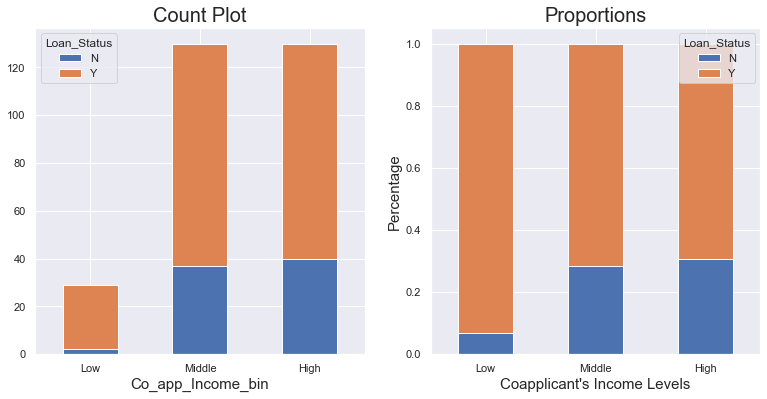

In [38]:
#Checking for co-applicant income

bins = [0,1213.5, 2330.5, 33837.5]
groups = ['Low', 'Middle', 'High']
X_train['Co_app_Income_bin'] = pd.cut(x = X_train['CoapplicantIncome'], bins = bins, labels = groups)

Coapp_Income_bin = pd.crosstab(index = X_train.Co_app_Income_bin, columns = y_train['Loan_Status'])

fig, ax = plt.subplots(1, 2, figsize = (13,6))

Coapp_Income_bin.plot(kind = 'bar', stacked = True, rot = 0, title = 'Count Plot', ax = ax[0]);

Coapp_Income_bin.div(Coapp_Income_bin.sum(1), axis = 0).plot(kind = 'bar', 
                                                             stacked = True, 
                                                             rot = 0, 
                                                             title = 'Proportions', 
                                                             ax = ax[1])

plt.xlabel("Coapplicant's Income Levels")
plt.ylabel('Percentage');

Here we can clearly see that if the coapplicant salary is low, there is a higher chance the loan will
get approved.

Therefore, it makes sense to sum up both of applicant and coapplicant salary and see its effect on the loan status.

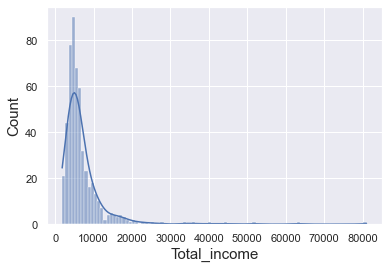

In [39]:
X_train['Total_income'] = X_train.ApplicantIncome + X_train.CoapplicantIncome
sns.histplot(X_train['Total_income'],kde = True);

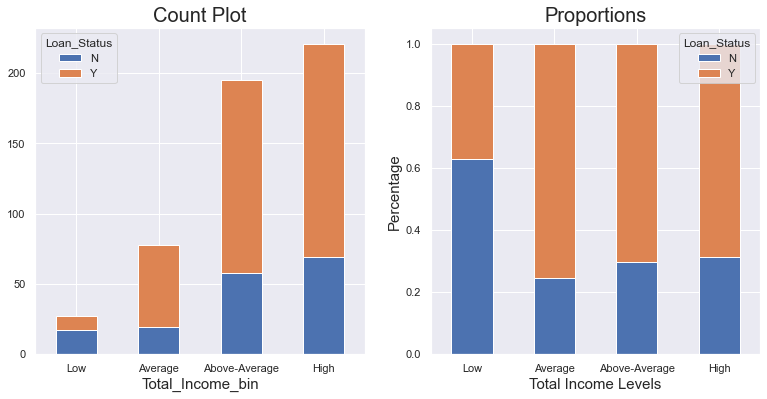

In [40]:
#Binning total income

bins = [0,2876.5, 3858.5, 5935.5, 81000.5] #Keeping same bins as main applicants incomes
groups = ['Low', 'Average', 'Above-Average', 'High']
X_train['Total_Income_bin'] = pd.cut(x = X_train['Total_income'], bins = bins, labels = groups)

Total_income_bin = pd.crosstab(index = X_train.Total_Income_bin, columns = y_train['Loan_Status'])

fig, ax = plt.subplots(1, 2, figsize = (13,6))

Total_income_bin.plot(kind = 'bar', stacked = True, rot = 0, title = 'Count Plot', ax = ax[0]);

Total_income_bin.div(Total_income_bin.sum(1), axis = 0).plot(kind = 'bar', 
                                                             stacked = True,
                                                             rot = 0, 
                                                             title = 'Proportions', 
                                                             ax = ax[1]);

plt.xlabel("Total Income Levels")
plt.ylabel('Percentage');

Here, applicants within the low total income range are more likely to get their loans not approved.

Next, I will creating a new feature called EMI. 
**EMI, which stands for equated monthly installment**, is the monthly amount payments we make towards a loan we opted for. “EMI payments include contributions towards both principal and interest on the loan amount. <br>
<br>
The mathematical formula to calculate EMI is: **EMI = [P x R x (1+R)^N]/[(1+R)^ (N-1)]** where 
* P= Loan amount, 
* r= interest rate, 
* n=tenure in number of months.<br>
<br>

Read more at:
https://economictimes.indiatimes.com/analysis/what-is-emi-and-how-is-it-calculated/articleshow/39880530.cms?utm_source=contentofinterest&utm_medium=text&utm_campaign=cppst
<br>
<br>
I will assume a interest rate of 10%

In [41]:
def emi(p,r,n):
    return (p * r * (1+r)**n)/((1+r)**(n-1)) 

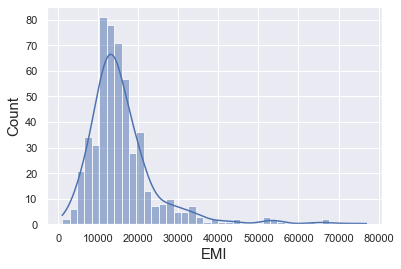

In [42]:
X_train['EMI'] = emi(X_train.LoanAmount, 0.1, X_train.Loan_Amount_Term)
sns.histplot(X_train['EMI'],kde = True);

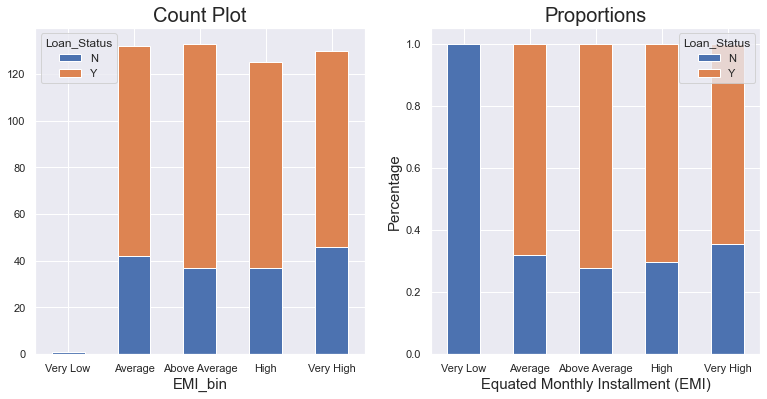

In [43]:
#Checking for EMI's effect on loan status

bins = [0,990.5, 11000.5, 14080.5, 18480.5, 77000.5] #Keeping same bins as main applicants incomes
groups = ['Very Low', 'Average', 'Above Average', 'High', 'Very High']

X_train['EMI_bin'] = pd.cut(x = X_train['EMI'], bins = bins, labels = groups)

EMI_bin = pd.crosstab(index = X_train.EMI_bin, columns = y_train['Loan_Status'])

fig, ax = plt.subplots(1, 2, figsize = (13,6))

EMI_bin.plot(kind = 'bar', stacked = True, rot = 0, title = 'Count Plot', ax = ax[0]);

EMI_bin.div(EMI_bin.sum(1), axis = 0).plot(kind = 'bar', 
                                           stacked = True, 
                                           rot = 0, 
                                           title = 'Proportions', 
                                           ax = ax[1])

plt.xlabel("Equated Monthly Installment (EMI)")
plt.ylabel('Percentage');

No significant effect is found on the loan Status

Next, I will create debt-to-income ratio, which will be monthly debt payments divided by monthly income. This represents, how much balance will the applicant have after paying the monthly instalment. The lower the DTI; the less risky you are to lenders. 

In [44]:
X_train['Debt_income_ratio'] = X_train['EMI']/X_train['Total_income']

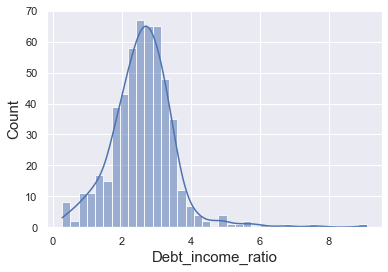

In [45]:
sns.histplot(X_train['Debt_income_ratio'], kde = True);

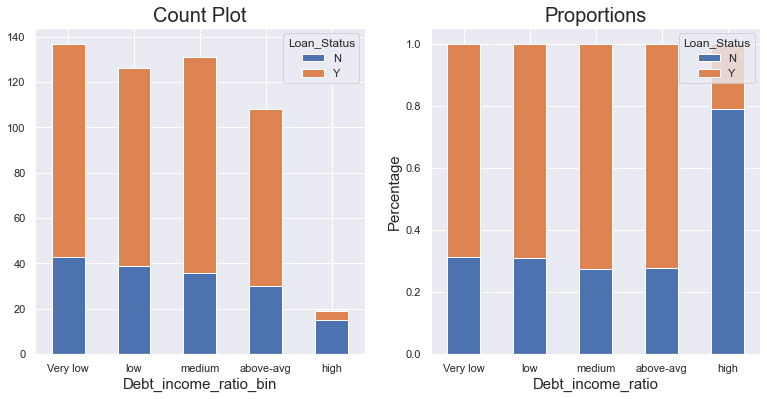

In [46]:
bins = [-0.5, 2.15, 2.64, 3.09, 4.08, 10] #Keeping same bins as main applicants incomes
groups = ['Very low', 'low', 'medium', 'above-avg', 'high']

X_train['Debt_income_ratio_bin'] = pd.cut(x = X_train['Debt_income_ratio'], bins = bins, labels = groups)

Debt_income_ratio_bin = pd.crosstab(index = X_train.Debt_income_ratio_bin, columns = y_train['Loan_Status'])

fig, ax = plt.subplots(1, 2, figsize = (13,6))

Debt_income_ratio_bin.plot(kind = 'bar', stacked = True, rot = 0, title = 'Count Plot', ax = ax[0]);

Debt_income_ratio_bin.div(Debt_income_ratio_bin.sum(1), axis = 0).plot(kind = 'bar', 
                                                                 stacked = True,
                                                                 rot = 0, 
                                                                 title = 'Proportions', 
                                                                 ax = ax[1]);
plt.xlabel("Debt_income_ratio")
plt.ylabel('Percentage');

Applicants with the potential to have negative balance after paying EMI are more likely to get their loan applications rejected.

In [47]:
#dropping binned features. There were only for eda purposes.

X_train.drop(['Loan_amt_bin', 'Income_bin', 'Co_app_Income_bin', 'Total_Income_bin', 'EMI_bin',
              'Debt_income_ratio_bin', 'ApplicantIncome', 'CoapplicantIncome'], axis = 1, inplace = True)

In [48]:
#Creating total income, emi and balance income feature for x_test and TEST_DF

X_test['Total_income'] = X_test.ApplicantIncome + X_test.CoapplicantIncome
TEST_DF['Total_income'] = TEST_DF.ApplicantIncome + TEST_DF.CoapplicantIncome

X_test['EMI'] = emi(X_test.LoanAmount, 0.1, X_test.Loan_Amount_Term)
TEST_DF['EMI'] = emi(TEST_DF.LoanAmount, 0.1, TEST_DF.Loan_Amount_Term)

X_test['Debt_income_ratio'] = X_test['EMI']/X_test['Total_income']
TEST_DF['Debt_income_ratio'] = TEST_DF['EMI']/TEST_DF['Total_income']

In [49]:
#Dropping columns

X_test.drop(['ApplicantIncome', 'CoapplicantIncome'], axis = 1, inplace = True)
TEST_DF.drop(['ApplicantIncome', 'CoapplicantIncome'], axis = 1, inplace = True)

In [50]:
target_map = {'N':0, 'Y':1}

y_train.Loan_Status = y_train.Loan_Status.map(target_map)
y_test.Loan_Status = y_test.Loan_Status.map(target_map)

In [57]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Total_income', 'EMI', 'Debt_income_ratio'],
      dtype='object')

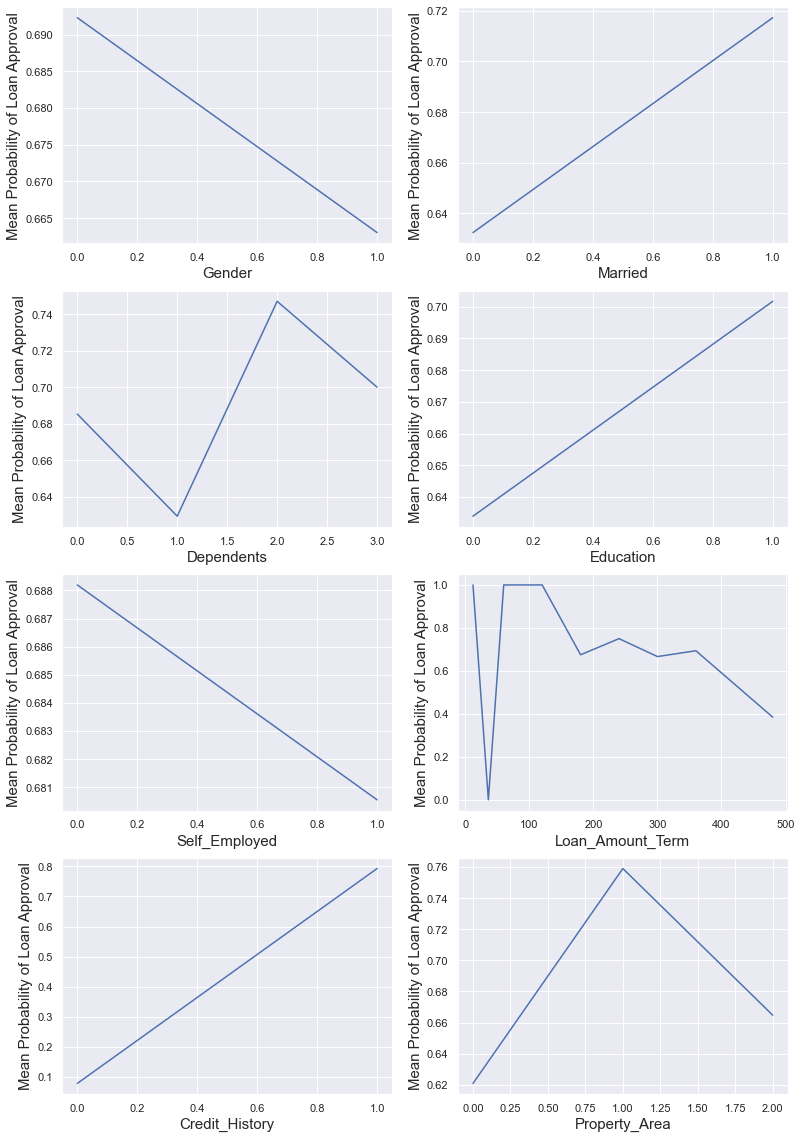

In [75]:
encode_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed','Loan_Amount_Term', 
               'Credit_History', 'Property_Area']

fig, axes = plt.subplots(4,2, figsize = (13,20))

for col, ax in zip(encode_cols, axes.flatten()):
    pd.concat([X_train, y_train],axis = 1).groupby(col).mean()['Loan_Status'].plot(ax = ax);
    ax.set_ylabel('Mean Probability of Loan Approval')

* **Gender**: 1 represents female, 0 represents male in the x axis. Male applicants have a higher proability of getting tloan approval compared to female applicants (69 % probability for male compared to around 66.5 % for female).<br>
<br>
* **Married**: 1 represents married and 0 the opposite. MArried applicant have a higher probability of 72% of loan approval compared to unmarried applicants (around 64 %).<br>
<br>
* **Dependents**: It seems that the relation with the target variable was not captured properly, as it shows those with around 2 dependents have a much higher probability to get their loan approved. <br>
<br>
* **Education**: Graduates have a higher probabilty of loan approval (70 %) compared to non-graduates (64 %) <br>
<br>
* **Self Employed**: HEre the probability of loan approval for those who are self-employed and not are roughly the same (68.8 % and 68.1% respectively). <br>
<br>
* **Loan amount term**: Again, the relation is not properly captured by the encoding. But in general, the lower is the loan term, the higher the probability of loan approval. <br>
<br>
* **Credit History**: This is the most deciding attribute for loan approval. Those with credit history of 1.0 (Good loan history) has 80% probability of loan approval compared to those with 0.0 credit history (bad history loan) having a loan approval probability of only 10 %. <br>
<br>
* **Property Area**: 0 - rural, 1 - semi-urban, 2 - urban. Here, applicants from semi urban property area have a higher probability of loan approval. Those from rural property have the lowest loan approval probability. <br>
<br>
<br>

The rest of the features are discretized features, where the probability of getting loan approved varies across each of the bins. Hence, the relationship of these features with the target variable is quite obscured

Most of the categorical variables show a monotonic relation with the target variable. A monotnoic relationship is same as correlation, where increase in one variable can increase the other, or the opposite can happen - increaseing one varibale may decrease the other variable.<br>
<br>
For other features, the relationship is not so apparent. Hence, in order to maintain the information of a relationship between the target and these features, the categorical variables can be encoded with guidance of target variable. For all of the vategorical variables, I will encode them using **Mean Encoding**. <br>
<br>

*Mean encoding implies replacing the category by the average target value for that category.*<br>
<br>
The categorical features needs to be first cast to 'object' datatype in order to be encoded.

In [76]:
for col in encode_cols:
    X_train[col] = X_train[col].astype('object')
    X_test[col] = X_test[col].astype('object')
    TEST_DF[col] = TEST_DF[col].astype('object')

In [79]:
from feature_engine.encoding import WoEEncoder
    
woe_enc = WoEEncoder(variables=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                                'Credit_History', 'Property_Area'])

woe_enc.fit(X_train, y_train.Loan_Status)

X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)
TEST_DF = woe_enc.transform(TEST_DF)

print(woe_enc.encoder_dict_)

{'Gender': {0.0: 0.02414743062239079, 1.0: -0.10989612590577316}, 'Married': {0.0: -0.24411655597228846, 1.0: 0.14413725629617619}, 'Dependents': {0.0: -0.008796725096963293, 1.0: -0.2579386563252689, 2.0: 0.29656203094338324, 3.0: 0.06051507479326561}, 'Education': {0.0: -0.23767497525693024, 1.0: 0.06867838543242663}, 'Self_Employed': {0.0: 0.0049160686945031035, 1.0: -0.030456703412460977}, 'Credit_History': {0.0: -3.2577031934071985, 1.0: 0.5550598129551189}, 'Property_Area': {0.0: -0.2933489045398163, 1.0: 0.36028188646011855, 2.0: -0.10229366777710712}}


In [80]:
from feature_engine.encoding import MeanEncoder

mean_enc = MeanEncoder(variables=['Loan_Amount_Term'])

mean_enc.fit(X_train, y_train.Loan_Status)

X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)
TEST_DF = mean_enc.transform(TEST_DF)

print(mean_enc.encoder_dict_)

{'Loan_Amount_Term': {12.0: 1.0, 36.0: 0.0, 60.0: 1.0, 84.0: 1.0, 120.0: 1.0, 180.0: 0.675, 240.0: 0.75, 300.0: 0.6666666666666666, 360.0: 0.6936936936936937, 480.0: 0.38461538461538464}}


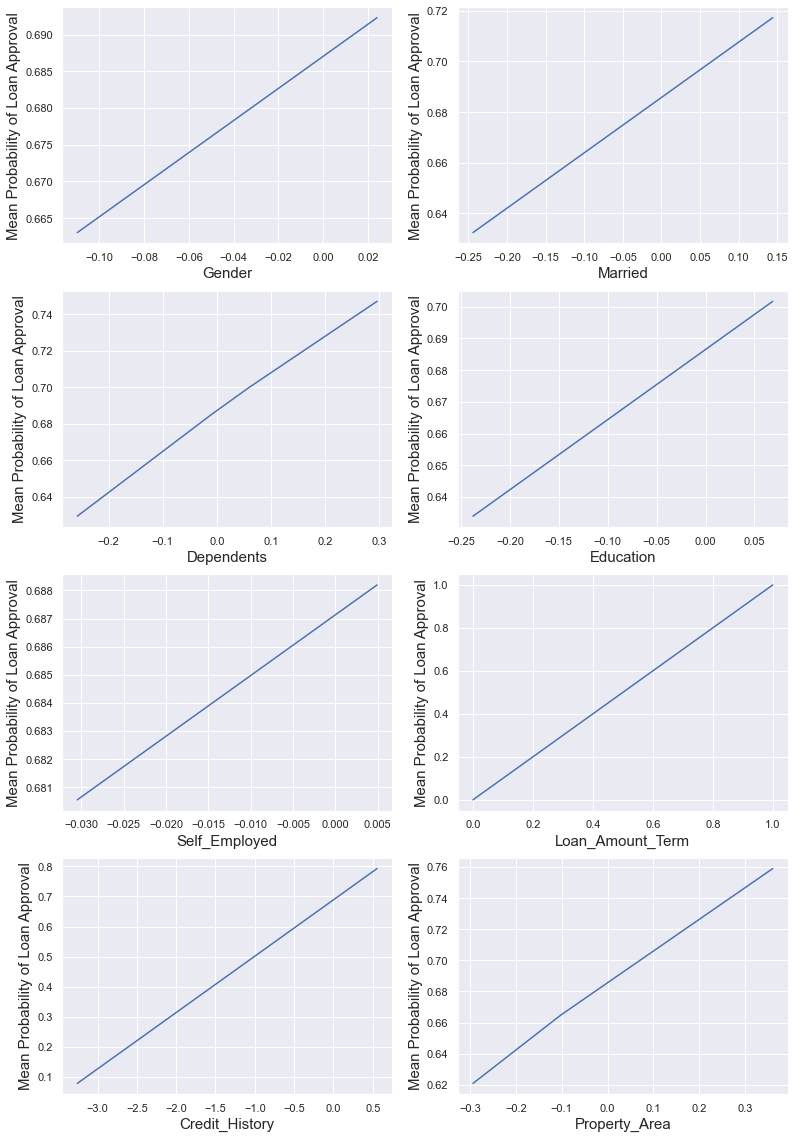

In [81]:
encode_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed','Loan_Amount_Term', 
               'Credit_History', 'Property_Area']

fig, axes = plt.subplots(4,2, figsize = (13,20))

for col, ax in zip(encode_cols, axes.flatten()):
    pd.concat([X_train, y_train],axis = 1).groupby(col).mean()['Loan_Status'].plot(ax = ax);
    ax.set_ylabel('Mean Probability of Loan Approval')

As is evident, all categorical features have a monotonic relationship with the target variable.

In [82]:
print(X_train.isna().sum()), 
print()
print(X_test.isna().sum())
print()
print(TEST_DF.isna().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_income         0
EMI                  0
Debt_income_ratio    0
dtype: int64

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_income         0
EMI                  0
Debt_income_ratio    0
dtype: int64

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     2
Credit_History       0
Property_Area        0
Total_income         0
EMI                  0
Debt_income_ratio    0
dtype: int64


In [85]:
TEST_DF.fillna(TEST_DF.Loan_Amount_Term.mode()[0], inplace = True)

In [86]:
print(X_train.isna().sum()), 
print()
print(X_test.isna().sum())
print()
print(TEST_DF.isna().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_income         0
EMI                  0
Debt_income_ratio    0
dtype: int64

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_income         0
EMI                  0
Debt_income_ratio    0
dtype: int64

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_income         0
EMI                  0
Debt_income_ratio    0
dtype: int64


In [87]:
#Saving to csv

X_train.to_csv('X_train_preprocessed.csv', index = False)
X_test.to_csv('X_test_preprocessed.csv', index = False)
TEST_DF.to_csv('TEST_DF_preprocessed.csv', index = False)

#target variables

y_train.to_csv('y_train_preprocessed.csv', index = False)
y_test.to_csv('y_test_preprocessed.csv', index = False)